<a href="https://colab.research.google.com/github/cnorteye/cs599_deep/blob/main/cs599_Lab1_Problem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Running on: CPU

Training with SGD optimizer...

Epoch 1: Loss=263.4875, Train Acc=0.7418, Val Acc=0.7455
Epoch 0: Time taken = 6.2916 seconds
Epoch 2: Loss=246.0361, Train Acc=0.7709, Val Acc=0.7718
Epoch 1: Time taken = 2.3553 seconds
Epoch 3: Loss=242.3729, Train Acc=0.7808, Val Acc=0.7805
Epoch 2: Time taken = 2.3769 seconds
Epoch 4: Loss=240.5537, Train Acc=0.7853, Val Acc=0.7868
Epoch 3: Time taken = 2.3877 seconds
Epoch 5: Loss=239.3810, Train Acc=0.7904, Val Acc=0.7911
Epoch 4: Time taken = 2.3739 seconds


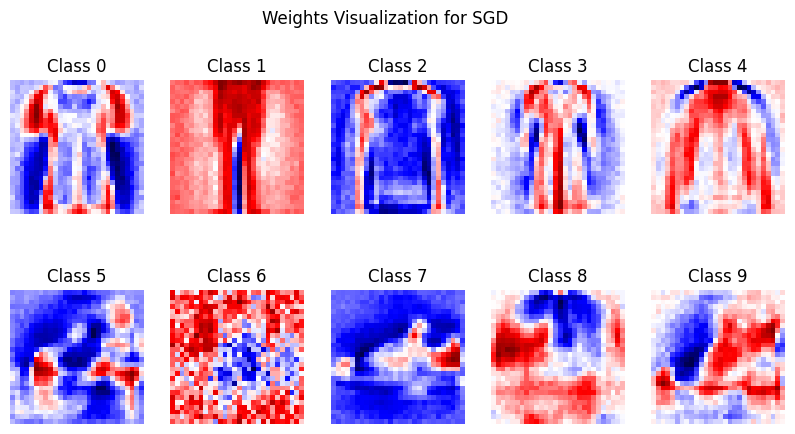


Training with Adam optimizer...

Epoch 1: Loss=268.0856, Train Acc=0.7341, Val Acc=0.7372
Epoch 0: Time taken = 4.2773 seconds
Epoch 2: Loss=247.1355, Train Acc=0.7655, Val Acc=0.7693
Epoch 1: Time taken = 3.5558 seconds
Epoch 3: Loss=241.4091, Train Acc=0.8065, Val Acc=0.8057
Epoch 2: Time taken = 3.5065 seconds
Epoch 4: Loss=237.7633, Train Acc=0.8179, Val Acc=0.8171
Epoch 3: Time taken = 5.9755 seconds
Epoch 5: Loss=235.7948, Train Acc=0.8254, Val Acc=0.8240
Epoch 4: Time taken = 3.5500 seconds


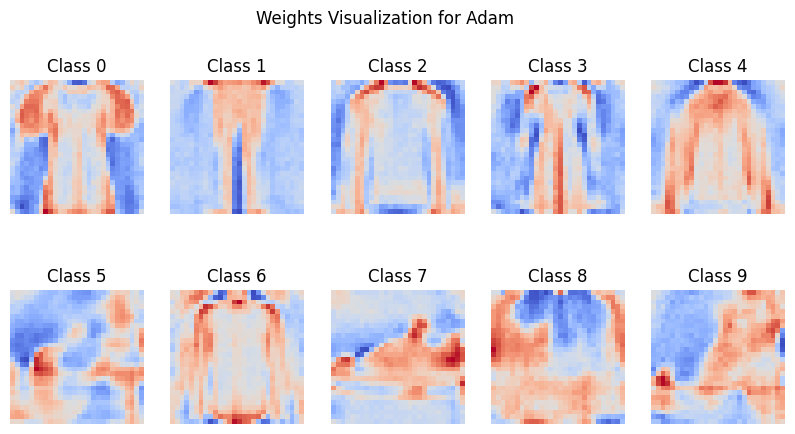


Training with RMSprop optimizer...

Epoch 1: Loss=267.0144, Train Acc=0.7241, Val Acc=0.7207
Epoch 0: Time taken = 3.4632 seconds
Epoch 2: Loss=248.4134, Train Acc=0.7512, Val Acc=0.7470
Epoch 1: Time taken = 5.9824 seconds
Epoch 3: Loss=244.3803, Train Acc=0.7632, Val Acc=0.7572
Epoch 2: Time taken = 2.8688 seconds
Epoch 4: Loss=242.3010, Train Acc=0.7715, Val Acc=0.7645
Epoch 3: Time taken = 2.9792 seconds
Epoch 5: Loss=240.9802, Train Acc=0.7777, Val Acc=0.7712
Epoch 4: Time taken = 4.2412 seconds


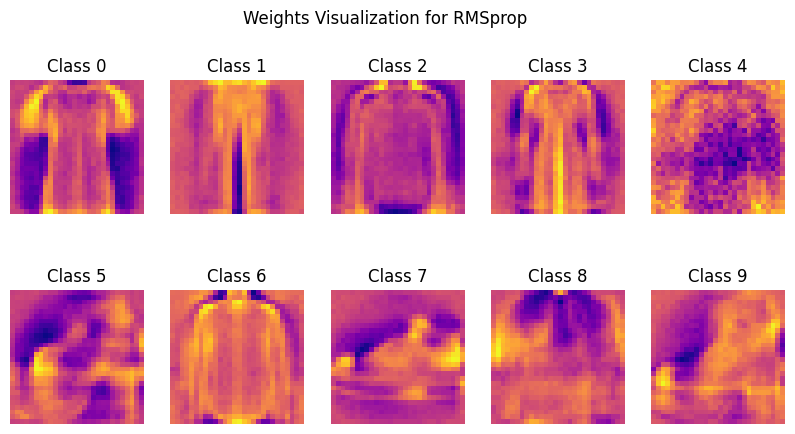

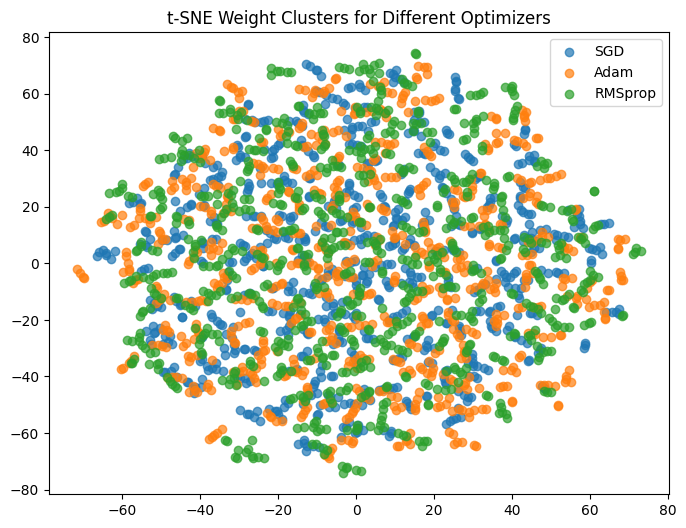

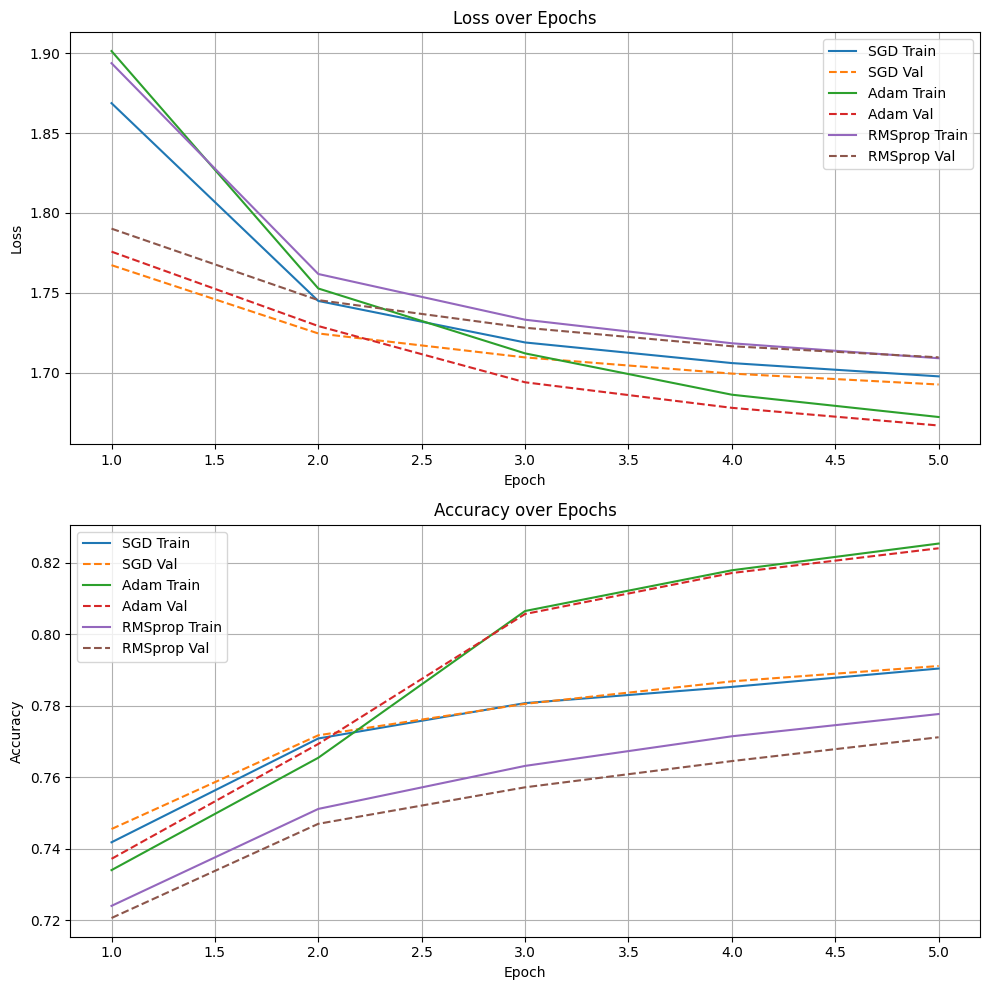

In [ ]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import fashion_mnist

# Load and preprocess dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0  # Normalize data

# Flatten images
train_images_flat = train_images.reshape(-1, 28*28)
test_images_flat = test_images.reshape(-1, 28*28)

# Train-validation split (80-20)
val_size = int(0.4 * len(train_images_flat))
train_images_split, val_images = train_images_flat[:-val_size], train_images_flat[-val_size:]
train_labels_split, val_labels = train_labels[:-val_size], train_labels[-val_size:]

# TensorFlow dataset
batch_size = 256
train_data = tf.data.Dataset.from_tensor_slices((train_images_split, train_labels_split)).shuffle(10000).batch(batch_size)
val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)
test_data = tf.data.Dataset.from_tensor_slices((test_images_flat, test_labels)).batch(batch_size)

# Check if GPU is available
device_name = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Running on: {device_name}")

# Logistic Regression Model
class LogisticRegressionModel(tf.Module):
    def __init__(self):
        super().__init__()
        self.W = tf.Variable(tf.random.normal([28*28, 10], mean=0.0, stddev=0.01))
        self.b = tf.Variable(tf.zeros([10]))

    def __call__(self, x):
        x = tf.cast(x, tf.float32)
        return tf.nn.softmax(tf.matmul(x, self.W) + self.b)

# Loss function
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True))

# Training step
def train_step(model, images, labels, optimizer, lambda_reg=0.0):
    with tf.GradientTape() as tape:
        logits = model(images)
        loss = loss_fn(labels, logits) + lambda_reg * tf.nn.l2_loss(model.W)
    grads = tape.gradient(loss, [model.W, model.b])
    optimizer.apply_gradients(zip(grads, [model.W, model.b]))
    return loss

# Optimizers to test
optimizers_to_try = {
    "SGD": tf.optimizers.SGD(learning_rate=0.5),
    "Adam": tf.optimizers.Adam(learning_rate=0.001),
    "RMSprop": tf.optimizers.RMSprop(learning_rate=0.001)
}

# Evaluate accuracy
def evaluate_accuracy(dataset, model):
    correct, total = 0, 0
    for batch_images, batch_labels in dataset:
        preds = model(batch_images)
        correct += np.sum(np.argmax(preds.numpy(), axis=1) == batch_labels.numpy())
        total += batch_labels.shape[0]
    return correct / total

# Plot training images
def plot_images(images, y, yhat=None):
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='binary')
        xlabel = f"True: {y[i]}" if yhat is None else f"True: {y[i]}, Pred: {yhat[i]}"
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Plot learned weights
def plot_weights(weights, optimizer_name):
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    cmap_options = ["seismic", "coolwarm", "plasma"]  # Different colormaps for differentiation
    cmap = cmap_options[list(optimizers_to_try.keys()).index(optimizer_name)]

    for i, ax in enumerate(axes.flat):
        image = weights[:, i].reshape(28, 28)
        ax.imshow(image, cmap=cmap)
        ax.set_title(f"Class {i}")
        ax.axis("off")
    plt.suptitle(f"Weights Visualization for {optimizer_name}")
    plt.show()

# Train models with different optimizers
history_dict = {}

for opt_name, optimizer in optimizers_to_try.items():
    print(f"\nTraining with {opt_name} optimizer...\n")

    model = LogisticRegressionModel()  # Fresh model instance
    history = {"train_loss": [], "val_loss": [], "train_accuracy": [], "val_accuracy": []}

    for epoch in range(5):  # Increase epochs for better results
        start_time = time.time()
        epoch_loss = 0
        for batch_images, batch_labels in train_data:
            loss = train_step(model, batch_images, batch_labels, optimizer)
            epoch_loss += loss.numpy()

        train_acc = evaluate_accuracy(train_data, model)
        val_acc = evaluate_accuracy(val_data, model)

        history["train_loss"].append(epoch_loss / len(train_data))
        history["val_loss"].append(loss_fn(val_labels, model(val_images)).numpy())
        history["train_accuracy"].append(train_acc)
        history["val_accuracy"].append(val_acc)

        print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        end_time = time.time()
        epoch_time = end_time - start_time
        print(f"Epoch {epoch}: Time taken = {epoch_time:.4f} seconds")

    history_dict[opt_name] = history
    plot_weights(model.W.numpy(), opt_name)

# t-SNE and K-Means Clustering of Weights
plt.figure(figsize=(8, 6))

for opt_name, _ in history_dict.items():
    model = LogisticRegressionModel()
    weights = model.W.numpy()

    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    weights_tsne = tsne.fit_transform(weights)

    plt.scatter(weights_tsne[:, 0], weights_tsne[:, 1], label=opt_name, alpha=0.7)

plt.legend()
plt.title("t-SNE Weight Clusters for Different Optimizers")
plt.show()

# Plot loss & accuracy trends
epochs = range(1, 6)
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

for opt_name, history in history_dict.items():
    axs[0].plot(epochs, history["train_loss"], label=f"{opt_name} Train")
    axs[0].plot(epochs, history["val_loss"], '--', label=f"{opt_name} Val")
axs[0].set_title("Loss over Epochs")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[0].grid(True)

for opt_name, history in history_dict.items():
    axs[1].plot(epochs, history["train_accuracy"], label=f"{opt_name} Train")
    axs[1].plot(epochs, history["val_accuracy"], '--', label=f"{opt_name} Val")
axs[1].set_title("Accuracy over Epochs")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()



